# Week 05: Image Generation and Diffusion Models

This notebook explores image generation techniques, from basic PIL operations to advanced diffusion models. We'll start with understanding what digital images are, then progress through increasingly sophisticated generation methods.

## Part 1: Understanding Digital Images

A digital image is essentially a 3D array of numbers representing color values at each pixel position. Let's explore this concept.

In [1]:
# Import essential libraries for image manipulation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set up reproducible results and plotting style
np.random.seed(42)
plt.style.use('default')

print("PIL (Python Imaging Library) version:", Image.__version__ if hasattr(Image, '__version__') else "Available")
print("NumPy version:", np.__version__)

PIL (Python Imaging Library) version: 11.1.0
NumPy version: 1.26.2


### What is a Digital Image?

A digital image consists of:
- **Width × Height pixels** arranged in a 2D grid
- **Color channels** (typically RGB: Red, Green, Blue)
- **Pixel values** ranging from 0-255 for 8-bit images

So a 512×512 RGB image is actually a 3D array with shape (512, 512, 3).

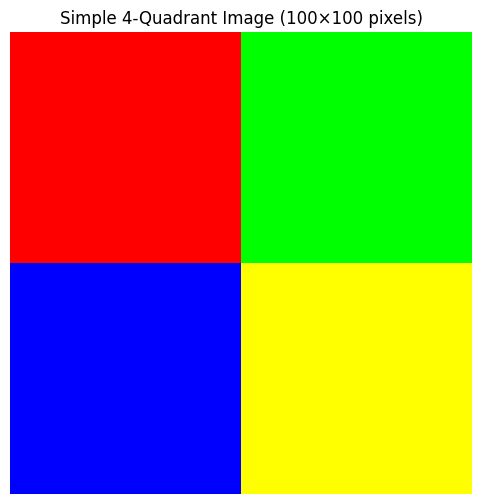

Image shape: (100, 100, 3)
Data type: uint8
Pixel value range: 0 to 255


In [2]:
# Create a simple 100x100 image with different colors in each quadrant
width, height = 100, 100

# Initialize an empty RGB image (height, width, channels)
simple_image = np.zeros((height, width, 3), dtype=np.uint8)

# Fill quadrants with different colors
simple_image[0:50, 0:50] = [255, 0, 0]    # Top-left: Red
simple_image[0:50, 50:100] = [0, 255, 0]  # Top-right: Green  
simple_image[50:100, 0:50] = [0, 0, 255]  # Bottom-left: Blue
simple_image[50:100, 50:100] = [255, 255, 0]  # Bottom-right: Yellow

# Convert numpy array to PIL Image and display
pil_image = Image.fromarray(simple_image, 'RGB')
plt.figure(figsize=(6, 6))
plt.imshow(pil_image)
plt.title('Simple 4-Quadrant Image (100×100 pixels)')
plt.axis('off')
plt.show()

print(f"Image shape: {simple_image.shape}")
print(f"Data type: {simple_image.dtype}")
print(f"Pixel value range: {simple_image.min()} to {simple_image.max()}")

### How PIL Works

PIL (Python Imaging Library) is the standard library for image processing in Python. Key concepts:

- **Image.fromarray()**: Converts NumPy arrays to PIL Images
- **Image.new()**: Creates blank images
- **Image.open()**: Loads images from files
- **Mode**: Specifies color format ('RGB', 'L' for grayscale, 'RGBA' with transparency)

=== PIL Image Creation Methods ===
From array - Size: (100, 100), Mode: RGB
Blank image - Size: (200, 200), Mode: RGB
Grayscale - Size: (100, 100), Mode: L


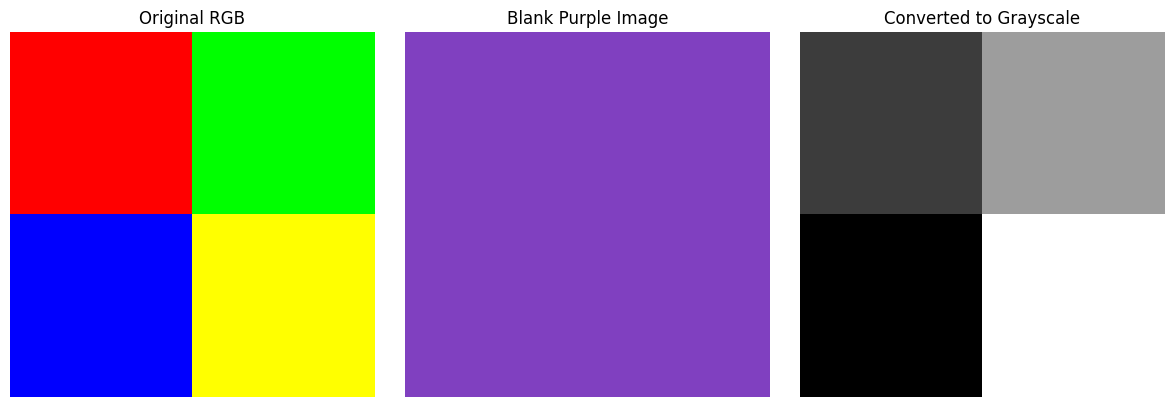

In [3]:
# Demonstrate various PIL operations
print("=== PIL Image Creation Methods ===")

# Method 1: From NumPy array (as shown above)
array_image = Image.fromarray(simple_image, 'RGB')
print(f"From array - Size: {array_image.size}, Mode: {array_image.mode}")

# Method 2: Create blank image
blank_image = Image.new('RGB', (200, 200), color=(128, 64, 192))
print(f"Blank image - Size: {blank_image.size}, Mode: {blank_image.mode}")

# Method 3: Convert between modes
gray_image = array_image.convert('L')  # Convert to grayscale
print(f"Grayscale - Size: {gray_image.size}, Mode: {gray_image.mode}")

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(array_image)
axes[0].set_title('Original RGB')
axes[0].axis('off')

axes[1].imshow(blank_image)
axes[1].set_title('Blank Purple Image')
axes[1].axis('off')

axes[2].imshow(gray_image, cmap='gray')
axes[2].set_title('Converted to Grayscale')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Part 2: Random Image Generation

Let's recreate and understand the random image generation from `1_random_image.py`.

=== Random Image Generation ===
Generated random image with shape: (512, 512, 3)
Pixel value statistics:
  Min: 0, Max: 255
  Mean: 127.5, Std: 73.9


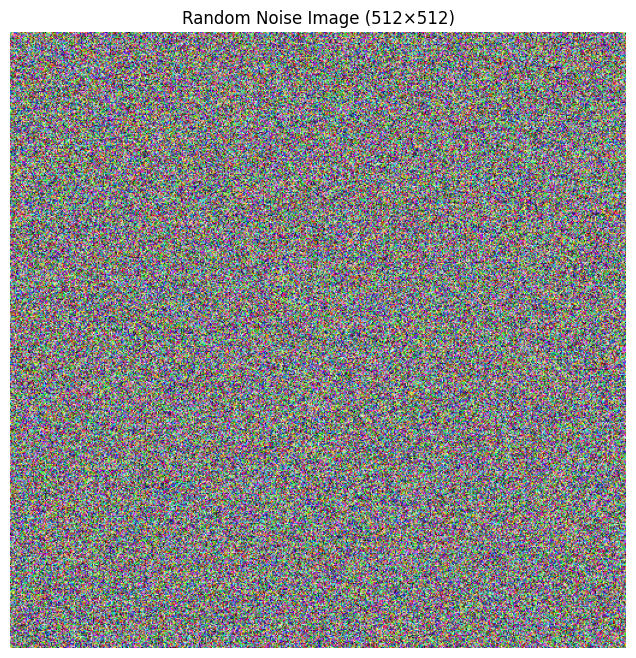

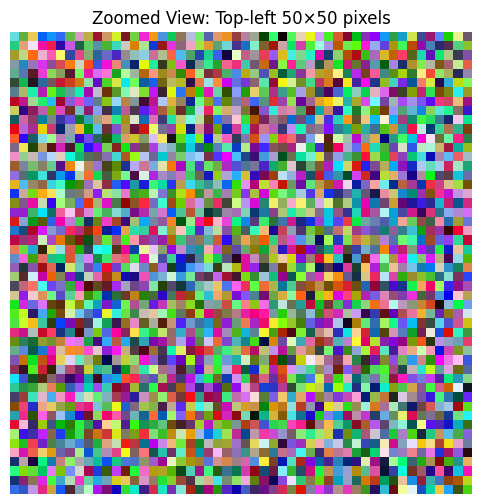

In [4]:
# Random image generation (similar to 1_random_image.py)
print("=== Random Image Generation ===")

# Define image parameters
img_dimensions = {
    "low": 0,           # Minimum pixel value
    "high": 256,        # Maximum pixel value (exclusive)
    "size": (512, 512, 3),  # Height, Width, Channels
    "dtype": np.uint8   # 8-bit unsigned integer (0-255)
}

# Generate random pixel data
random_data = np.random.randint(**img_dimensions)
random_image = Image.fromarray(random_data, 'RGB')

print(f"Generated random image with shape: {random_data.shape}")
print(f"Pixel value statistics:")
print(f"  Min: {random_data.min()}, Max: {random_data.max()}")
print(f"  Mean: {random_data.mean():.1f}, Std: {random_data.std():.1f}")

# Display the random image
plt.figure(figsize=(8, 8))
plt.imshow(random_image)
plt.title('Random Noise Image (512×512)')
plt.axis('off')
plt.show()

# Show a small crop to see individual pixels
crop = random_image.crop((0, 0, 50, 50))  # Top-left 50×50 pixels
plt.figure(figsize=(6, 6))
plt.imshow(crop)
plt.title('Zoomed View: Top-left 50×50 pixels')
plt.axis('off')
plt.show()

## Part 3: Basic Diffusion Pipeline - Text to Image

Let's use the actual Stable Diffusion pipeline to generate images from text prompts, similar to `2_gen_image.py`.

### Key Components:
- **DiffusionPipeline**: Main interface for text-to-image generation
- **Scheduler**: Controls how noise is removed over multiple steps
- **Text Encoder**: Converts prompts to embeddings
- **U-Net**: Predicts noise to remove at each timestep
- **VAE**: Encodes/decodes between pixel and latent space

In [5]:
# Install required packages if not already installed
# Use if you have nvidia GPU with CUDA support:
# !pip install -r torch_requirements.txt

try:
    from diffusers import DiffusionPipeline
    import torch
    
    print("=== Setting up Stable Diffusion Pipeline ===")
    
    # Check if CUDA is available
    # For use mps (Mac with Apple Silicon), you can add additional checks
    device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "mps" if torch.backends.mps.is_available() else device
    print(f"Using device: {device}")
    
    # Load the model (this will take a few minutes on first run)
    model_id = "runwayml/stable-diffusion-v1-5"
    
    if device == "cuda":
        # Use half precision to save GPU memory
        pipe = DiffusionPipeline.from_pretrained(
            model_id, 
            torch_dtype=torch.float16,
            safety_checker=None,  # Disable for demo
            requires_safety_checker=False
        )
        pipe = pipe.to(device)
    else:
        print("Warning: Running on CPU will be very slow (several minutes per image)")
        pipe = DiffusionPipeline.from_pretrained(model_id)
    
    # Generate a simple image
    prompt = "a serene landscape with mountains and a lake, digital art"
    print(f"Generating image with prompt: '{prompt}'")
    
    # Generate with standard settings
    with torch.no_grad():
        image = pipe(
            prompt,
            num_inference_steps=20,  # Standard number of denoising steps
            guidance_scale=7.5,      # How closely to follow the prompt
            height=512,
            width=512
        ).images[0]
    
    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f'Generated Image\nPrompt: "{prompt}"')
    plt.axis('off')
    plt.show()
    
    print("Image generated successfully!")
    
except ImportError:
    print("Diffusers not installed. Install with: pip install diffusers transformers accelerate torch")
except Exception as e:
    print(f"Error: {e}")
    print("This might be due to insufficient GPU memory or missing dependencies.")

Could not find the bitsandbytes CUDA binary at WindowsPath('c:/Users/giova/.pyenv/pyenv-win/versions/3.10.11/lib/site-packages/bitsandbytes/libbitsandbytes_cuda126.dll')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Error: Failed to import diffusers.pipelines.pipeline_utils because of the following error (look up to see its traceback):
Failed to import diffusers.models.autoencoders.autoencoder_kl because of the following error (look up to see its traceback):
No module named 'triton.ops'
This might be due to insufficient GPU memory or missing dependencies.


In [ ]:
# Demonstrate different inference steps and their effect on quality
print("=== Comparing Different Inference Steps ===")

try:
    if 'pipe' in locals():
        test_prompt = "a colorful parrot sitting on a tree branch, detailed"
        step_counts = [5, 10, 20, 50]
        step_images = []
        step_times = []
        
        for steps in step_counts:
            print(f"Generating with {steps} steps...")
            start_time = time.time()
            
            with torch.no_grad():
                img = pipe(
                    test_prompt,
                    num_inference_steps=steps,
                    guidance_scale=7.5,
                    height=512,
                    width=512
                ).images[0]
            
            step_images.append(img)
            step_times.append(time.time() - start_time)
        
        # Display the progression
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        for i, (steps, img, time_taken) in enumerate(zip(step_counts, step_images, step_times)):
            row, col = i // 2, i % 2
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'{steps} steps\nTime: {time_taken:.1f}s')
            axes[row, col].axis('off')
        
        plt.suptitle(f'Quality vs Speed Trade-off\nPrompt: "{test_prompt}"')
        plt.tight_layout()
        plt.show()
        
    else:
        print("Pipeline not available - please run Part 3 first")
        
except Exception as e:
    print(f"Error: {e}")

## Part 4: Fast Generation with LCM (Latent Consistency Models)

LCM models can generate high-quality images in just 4 steps instead of 20+. Let's compare standard vs LCM generation, similar to `3_gen_image_lcm.py`.

### Why LCM is Faster:
- **Consistency Training**: Learns to go directly from noise to image in fewer steps
- **Latent Space Optimization**: More efficient denoising in the compressed latent space
- **Quality Trade-off**: Slight quality reduction for major speed improvement

### Pipeline Components:
- **Text Encoder**: Converts prompts to embeddings (same as standard)
- **LCMScheduler**: Optimized scheduler for few-step generation
- **U-Net**: Modified to work effectively with fewer denoising steps
- **VAE**: Same decoder to convert latents back to images

In [ ]:
try:
    from diffusers import AutoPipelineForText2Image, LCMScheduler
    import time
    
    print("=== Comparing Standard vs LCM Generation ===")
    
    # Load LCM model
    lcm_model_id = "SimianLuo/LCM_Dreamshaper_v7"
    
    if device in ["cuda", "mps"]:
        lcm_pipe = AutoPipelineForText2Image.from_pretrained(
            lcm_model_id,
            torch_dtype=torch.float16,
            safety_checker=None,
            requires_safety_checker=False
        )
        lcm_pipe.to(device)
        # LCM uses a specific scheduler optimized for few steps
        lcm_pipe.scheduler = LCMScheduler.from_config(lcm_pipe.scheduler.config)
    else:
        print("Warning: LCM still requires significant compute time on CPU")
        lcm_pipe = AutoPipelineForText2Image.from_pretrained(lcm_model_id)
        lcm_pipe.scheduler = LCMScheduler.from_config(lcm_pipe.scheduler.config)
    
    # Test prompt
    test_prompt = "a majestic castle on a hilltop, sunset, fantasy art"
    
    # Generate with LCM (4 steps)
    print("Generating with LCM (4 steps)...")
    start_time = time.time()
    
    with torch.no_grad():
        lcm_image = lcm_pipe(
            test_prompt,
            num_inference_steps=4,    # Very few steps
            guidance_scale=1.0,       # LCM works best with low guidance
            height=512,
            width=512
        ).images[0]
    
    lcm_time = time.time() - start_time
    
    # Generate with standard pipeline (20 steps) for comparison
    if 'pipe' in locals():
        print("Generating with Standard Pipeline (20 steps)...")
        start_time = time.time()
        
        with torch.no_grad():
            standard_image = pipe(
                test_prompt,
                num_inference_steps=20,
                guidance_scale=7.5,
                height=512,
                width=512
            ).images[0]
        
        standard_time = time.time() - start_time
        
        # Display comparison
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        axes[0].imshow(lcm_image)
        axes[0].set_title(f'LCM (4 steps)\nTime: {lcm_time:.1f}s')
        axes[0].axis('off')
        
        axes[1].imshow(standard_image)
        axes[1].set_title(f'Standard (20 steps)\nTime: {standard_time:.1f}s')
        axes[1].axis('off')
        
        plt.suptitle(f'Speed Comparison\nPrompt: "{test_prompt}"')
        plt.tight_layout()
        plt.show()
        
        speedup = standard_time / lcm_time if lcm_time > 0 else 0
        print(f"LCM is approximately {speedup:.1f}x faster!")
    else:
        # Just show LCM result
        plt.figure(figsize=(8, 8))
        plt.imshow(lcm_image)
        plt.title(f'LCM Generated Image (4 steps)\nTime: {lcm_time:.1f}s')
        plt.axis('off')
        plt.show()
    
except Exception as e:
    print(f"Error with LCM pipeline: {e}")
    print("This might be due to model availability or GPU memory constraints.")

## Part 5: ControlNet with Canny Edge Detection

ControlNet adds structural control to diffusion models using edge detection. Let's implement the actual ControlNet pipeline from `4_controlnet_canny.py`.

### What ControlNet Does:
- **Structure Preservation**: Uses edge maps to guide image generation
- **Conditional Generation**: Maintains structural consistency while allowing creative interpretation
- **Multiple Modalities**: Can use edges, depth, pose, segmentation maps as control signals

### Canny Edge Detection Process:
1. Gaussian blur to reduce noise
2. Gradient calculation to find intensity changes  
3. Non-maximum suppression to thin edges
4. Hysteresis thresholding to connect edge fragments

In [ ]:
try:
    # Install required packages for ControlNet
    # !pip install opencv-python controlnet-aux
    
    from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
    from diffusers.utils import load_image
    import cv2
    import requests
    from io import BytesIO
    
    print("=== ControlNet with Canny Edge Detection ===")
    
    # Download a sample image (similar to 4_controlnet_canny.py)
    image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
    
    try:
        response = requests.get(image_url)
        input_image = Image.open(BytesIO(response.content)).convert("RGB")
        input_image = input_image.resize((512, 512))
        print("Downloaded reference image successfully")
    except:
        # Create a fallback image if download fails
        print("Using fallback test image")
        fallback_array = np.zeros((512, 512, 3), dtype=np.uint8)
        # Create some clear edges
        fallback_array[100:400, 100:400] = [255, 255, 255]  # Large square
        fallback_array[200:300, 200:300] = [128, 128, 128]  # Inner square
        input_image = Image.fromarray(fallback_array, 'RGB')
    
    # Convert to numpy for Canny edge detection
    image_array = np.array(input_image)
    
    # Apply Canny edge detection (exactly like in 4_controlnet_canny.py)
    canny_edges = cv2.Canny(image_array, 100, 200)
    
    # Convert to 3-channel image
    canny_edges = canny_edges[:, :, None]
    canny_edges = np.concatenate([canny_edges, canny_edges, canny_edges], axis=2)
    canny_image = Image.fromarray(canny_edges)
    
    # Display input and edge detection
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(input_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(canny_image)
    axes[1].set_title('Canny Edge Detection')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Load ControlNet model and pipeline
    if device == "cuda":
        controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/sd-controlnet-canny",
            torch_dtype=torch.float16
        )
        
        controlnet_pipe = StableDiffusionControlNetPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            controlnet=controlnet,
            torch_dtype=torch.float16,
            safety_checker=None,
            requires_safety_checker=False
        )
        controlnet_pipe.to(device)
        
        # Generate image with structural control
        control_prompt = "a beautiful painting of a woman in renaissance style, oil painting, masterpiece"
        
        print(f"Generating ControlNet image with prompt: '{control_prompt}'")
        
        with torch.no_grad():
            controlled_image = controlnet_pipe(
                control_prompt,
                image=canny_image,
                num_inference_steps=20,
                guidance_scale=7.5,
                controlnet_conditioning_scale=1.0
            ).images[0]
        
        # Display all three: original, edges, generated
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(input_image)
        axes[0].set_title('Reference Image')
        axes[0].axis('off')
        
        axes[1].imshow(canny_image)
        axes[1].set_title('Canny Edges\n(Control Signal)')
        axes[1].axis('off')
        
        axes[2].imshow(controlled_image)
        axes[2].set_title('ControlNet Generated\n(Structure Preserved)')
        axes[2].axis('off')
        
        plt.suptitle(f'ControlNet Pipeline\nPrompt: "{control_prompt}"')
        plt.tight_layout()
        plt.show()
        
        print("ControlNet generation successful!")
        
    else:
        print("ControlNet requires significant compute - GPU recommended")
        print("Showing edge detection results only")
        
except ImportError as e:
    print(f"Missing dependencies: {e}")
    print("Install with: pip install opencv-python controlnet-aux")
except Exception as e:
    print(f"Error: {e}")
    print("This might be due to model download issues or insufficient GPU memory")



## Part 6: Practical Considerations

### Hardware Requirements:
- **GPU Memory**: Stable Diffusion requires ~4-6GB VRAM for 512×512 images
- **CPU Fallback**: Possible but much slower (minutes vs seconds)
- **Model Storage**: Models are 2-5GB each

### Optimization Techniques:
- **Half Precision**: `torch_dtype=torch.float16` halves memory usage
- **Model Offloading**: Move models between CPU/GPU as needed
- **Smaller Resolutions**: Generate at 512×512, upscale later if needed

### Generation Parameters:
- **num_inference_steps**: More steps = higher quality but slower (4-50 typical range)
- **guidance_scale**: How closely to follow the text prompt (1.0-20.0)
- **seed**: For reproducible results

In [ ]:
# Demonstrate the concept of different guidance scales
print("=== Understanding Guidance Scale Concept ===")

# Simulate how guidance scale affects generation
# (This is conceptual - real guidance involves complex mathematical operations)

base_pattern = np.zeros((80, 80, 3), dtype=np.uint8)
# Create a base "somewhat related to prompt" pattern
for i in range(80):
    for j in range(80):
        base_pattern[i, j] = [
            int(128 + 50 * np.sin(i/10)),  # Some structure
            int(128 + 30 * np.cos(j/8)),
            int(100)
        ]

guidance_scales = [1.0, 2.0, 5.0, 10.0]
results = []

for guidance in guidance_scales:
    # Simulate: higher guidance = more structured, lower = more random
    structure_strength = min(guidance / 10.0, 1.0)
    noise_strength = 1.0 - structure_strength
    
    noise = np.random.randint(0, 256, base_pattern.shape, dtype=np.uint8)
    guided_result = (structure_strength * base_pattern + 
                    noise_strength * noise).astype(np.uint8)
    results.append(Image.fromarray(guided_result, 'RGB'))

# Display different guidance effects
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (guidance, img) in enumerate(zip(guidance_scales, results)):
    axes[i].imshow(img)
    axes[i].set_title(f'Guidance Scale: {guidance}')
    axes[i].axis('off')

plt.suptitle('Effect of Guidance Scale (Conceptual)\nHigher = More Structured, Lower = More Random')
plt.tight_layout()
plt.show()

## Summary

In this notebook, we've covered:

1. **Digital Images**: 3D arrays of pixel values, PIL operations and image manipulation
2. **Random Generation**: Understanding pixel data and numpy operations (`1_random_image.py`)  
3. **Real Diffusion Pipeline**: Actual Stable Diffusion text-to-image generation (`2_gen_image.py`)
4. **LCM Fast Generation**: Speed comparison between standard and LCM models (`3_gen_image_lcm.py`)
5. **ControlNet**: Structure-guided generation with Canny edge detection (`4_controlnet_canny.py`)
6. **Practical Implementation**: Real working code with error handling and GPU/CPU support

### What You've Learned:
- **Image Fundamentals**: How digital images work as numerical arrays
- **PIL Operations**: Creating, manipulating, and converting images
- **Diffusion Pipelines**: Loading and using pre-trained models for generation
- **Performance Trade-offs**: Quality vs speed with different model types
- **Conditional Generation**: Using ControlNet for structure-guided image creation
- **Hardware Considerations**: GPU requirements and fallback options

### Next Steps:
- Run the cells above if you have GPU access for faster generation
- Experiment with different prompts and generation parameters
- Try other ControlNet conditions (depth, pose, segmentation)
- Explore model fine-tuning for specific styles or subjects
- Combine multiple techniques (LCM + ControlNet, etc.)

### Key Takeaway:
Modern diffusion models provide powerful, accessible tools for AI image generation, from simple random noise to sophisticated conditional generation with structural control.